In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


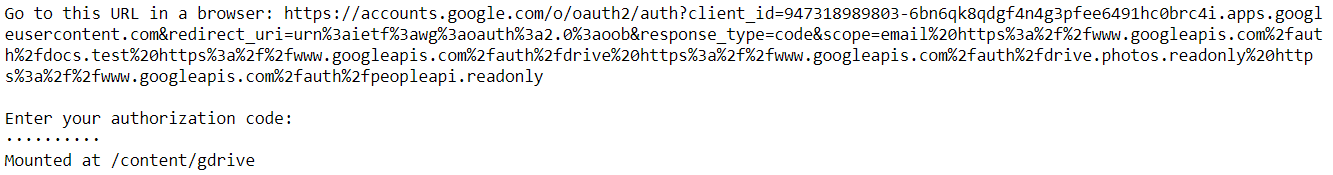

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [ ]:
# Neural Network Parameters
NN_COLOR           = 'single'                   # Input Color Space           ('single'/'multi')
NN_FINETUNE        = 'full'                     # Trainable Layers            ('full'/'classifier'/Starting Layer Name)
NN_WEIGHTS         = None                       # Pre-Trained Encoder Weights ('imagenet'/None)
TRAIN_SCHEME       = 'clean'                    # Training Scheme             ('clean'/'warm'/'freeze'/'resume')
DROPOUT            = False                      # Dropout Regularization
EPOCHS             = 7
AUX_EPOCHS         = 1
TTA                = True                       # Test-Time Augmentation
TTA_MODE           = 'mean'                     # TTA Aggregation             ('mean'/'maxconf')

# Learning Rate Hyperparameters
BASE_LR            = 1e-5
MODE_LR            = 'CLR'

# I/O Parameters
CLASS_NAMES        = ['nv','mel','bkl','bcc','akiec','vasc','df']
TRAIN_SAMPLES = 6009
VAL_SAMPLES = 2003
Test_samples = 2004
#dimensions of the image that will be inputed into the network (256x256)
image_size = 256

train_batch_size = 10
val_batch_size = 10

In [ ]:
TEST_DIR    = '/content/drive/MyDrive/base_dir2/test_dir2/testing_dir2'    
TEST_MODE   = 'val'                      # 'val'/'test'

def findScan(data, name, key):
    for i, dic in data.items():
    if dic[key] == name:        
        return i
    return -1

def test_io(path,mode):
  """"
  Input:  path
  Output: data[p] = {
      'id':
      'image':
      'label': }
  """
  if (mode=='test'):
    # Importing Images
    target_dir  = glob.glob(path+"/les/*.png")
    print("Number of Test Images:", len(target_dir))
    
    # Creating Dictionary
    data = {}
    for p in range(len(target_dir)):
        scan_id  =  target_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"\\", "")
        # Creating List of Dictionary                    
        data[p] = {'id'    : scan_id,
                   'image' : target_dir[p] }
  
  elif (mode=='val'):
    # Importing Images
    les_dir = glob.glob(path+"/les/*.png")
    nv_dir  = glob.glob(path+"/nv/*.png")
    print("Number of LES Images:", len(les_dir))
    print("Number of NV Images:",  len(nv_dir))
    
    # Creating Dictionary (df Scans)
    data = {}
    for p in range(len(les_dir)):
        scan_id  =  les_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/les\\", "")
      # Creating List of Dictionary                    
        data[p] = { 'id'    : scan_id,
                  'image' : les_dir[p],
                  'label' : 1 }                         # Label of df = 1

    # Creating Dictionary (NV Scans)
    for p in range(len(nv_dir)):
        scan_id  =  nv_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/nv\\", "")
      # Creating List of Dictionary                    
        data[p+len(les_dir)] = { 'id'    : scan_id,
                               'image' : nv_dir[p],
                               'label' : 0 }            # Label of bcc = 0
    return data



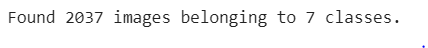

In [5]:
# Load Testing Dataset for Full Inference
test_dataset   = test_io(path=TEST_DIR, mode=TEST_MODE)

In [ ]:
if (NN_COLOR=='single'):
    DIM_CHANNELS = 3
    TRAIN_DIR    = '/content/drive/MyDrive/base_dir2/test_dir2/testing_dir2'
    VAL_DIR      = '/content/drive/MyDrive/base_dir2/test_dir2/val_dir2'
elif (NN_COLOR=='multi'):
    DIM_CHANNELS = 9
    TRAIN_DIR    = '/content/drive/MyDrive/base_dir2/test_dir2/testing_dir2'
    VAL_DIR      = '/content/drive/MyDrive/base_dir2/test_dir2/val_dir2'
    DATASET_MEAN = [0.610446659205108800, 0.5220753348750297000, 0.5095079890928187000,
                          0.545083657305597700, 0.3857680235700908000, 0.7072208299516552000,
                          1.435617385489288400, 1.1975180678760260000, 1.0724577830134300000] # [R,G,B,H,S,V,L,a,b]
    DATASET_STD  = [0.011219814446842410, 0.0114450729879776450, 0.0104303418370314950,
                          0.008512948157193818, 0.0082573833265490880, 0.0162066173083936020,
                          0.028451386706097037, 0.0018845362785246164, 0.0038278101960121606] # [R,G,B,H,S,V,L,a,b]

def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)   
    parts = parts[-2] == CLASS_NAMES # Generate One-Hot Encoded Label
    label= tf.argmax(tf.dtypes.cast(parts,tf.float32))     # Convert to Single Digit Label    
    if (NN_COLOR=='single'):
        img   = tf.io.read_file(file_path)                                                # Load RAW Data from File as String
        img   = tf.image.decode_jpeg(img, channels=DIM_CHANNELS)                          # Convert RAW Data to a 3D uint8 Tensor
        img   = tf.image.convert_image_dtype(img, tf.float32)                             # Convert to Floats in Range [0,1]
        img   = tf.image.crop_to_bounding_box(img,(IO_X-DIM_X)//2,                        # Crop Image to Central Target
                                                  (IO_Y-DIM_Y)//2,
                                                   DIM_X,DIM_Y)                                            
    elif (NN_COLOR=='multi'):
        img   = tf.io.read_file(file_path)                                                # Load RAW Data from File as String
        img   = tf.reshape(tf.io.decode_raw(img,tf.float32), [IO_X,IO_Y,DIM_CHANNELS])    # Convert RAW Data to a 3D float32 Reshaped Tensor
        img   = tf.image.convert_image_dtype(img, tf.float32)                             # Convert to Floats in Range [0,1]
        img   = tf.image.crop_to_bounding_box(img,(IO_X-DIM_X)//2,                        # Crop Image to Central Target
                                                  (IO_Y-DIM_Y)//2,
                                                   DIM_X,DIM_Y) 
    return img, label

def train_io(file_path):
    img, label = process_path(file_path) 
    if (NN_COLOR=='multi'):
    # Normalization (Mean=0, Std=1)
        mean_tensor = tf.constant(np.ones(shape=(DIM_X,DIM_Y,1))*DATASET_MEAN, tf.float32)
        std_tensor  = tf.constant(np.ones(shape=(DIM_X,DIM_Y,1))*DATASET_STD,  tf.float32)
        img         = (img-mean_tensor)/std_tensor
    return img, label
def val_io(file_path):
    img, label = process_path(file_path)                                                # Process Filepath to Obtain Image, Label Pair 
    if (NN_COLOR=='multi'):
        # Normalization (Mean=0, Std=1)
        mean_tensor = tf.constant(np.ones(shape=(DIM_X,DIM_Y,1))*DATASET_MEAN, tf.float32)
        std_tensor  = tf.constant(np.ones(shape=(DIM_X,DIM_Y,1))*DATASET_STD,  tf.float32)
        img         = (img-mean_tensor)/std_tensor
    return img, label


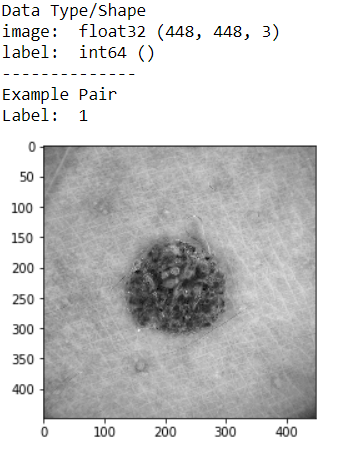

In [7]:
# Generate Dataset of Filepaths
train_list = tf.data.Dataset.list_files(str(TRAIN_DIR+'*/*'))
val_list   = tf.data.Dataset.list_files(str(VAL_DIR+'*/*'))

# Multiple Images Loaded/Processed in Parallel from Labeled One-Hot Encoded Dataset
labeled_train_data = train_list.map(train_io, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labeled_val_data   = val_list.map(val_io, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for image, label in labeled_train_data.take(1):
    print('Data Type/Shape')
    print('image: ', (image.numpy()).dtype, (image.numpy()).shape)
    print('label: ', (label.numpy()).dtype, (label.numpy()).shape)
    print('--------------\nExample Pair\nLabel: ', (label.numpy()))
    plt.imshow(image.numpy()[:,:,1],cmap='gray')
    plt.show()

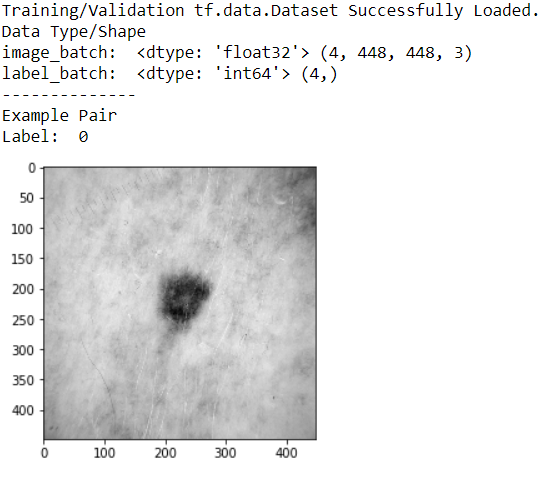

In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # Small Dataset: Load it only once, keep it in memory.
  # Large Dataset: Use `.cache(filename)` to cache preprocessing.
  
  if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)                  # Shuffle Dataset
    ds = ds.repeat()                                                  # Repeat Process
    ds = ds.batch(BATCH_SIZE)                                         # Load Data in Batches
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)       # Prefetch Data in Batches while Model is Training

    return ds

# Final tf.data.Dataset for Training/Validation
train_dataset            = prepare_for_training(labeled_train_data)
val_dataset              = prepare_for_training(labeled_val_data)

print('Training/Validation tf.data.Dataset Successfully Loaded.')
sample = 0

# Verify Example (Redundancy Check)
image_batch, label_batch = next(iter(train_dataset))
print('Data Type/Shape')
print('image_batch: ', image_batch.dtype, image_batch.shape)
print('label_batch: ', label_batch.dtype, label_batch.shape)
print('--------------\nExample Pair\nLabel: ', label_batch[sample].numpy())
plt.imshow(image_batch.numpy()[sample,:,:,1],cmap='gray')
plt.show()

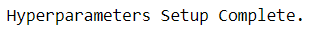

In [9]:
# Reduce Learning Rate on Plateau
if (MODE_LR=='RLRP'):
    COOLDOWN_RLRP      = 0
    PATIENCE_RLRP      = 3
    FACTOR_RLRP        = 0.5
    MIN_RLRP           = 1e-8

    RLRP               = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, cooldown=COOLDOWN_RLRP,
                                                                factor=FACTOR_RLRP, patience=PATIENCE_RLRP, min_lr=MIN_RLRP)
    CALLBACKS          = [RLRP]


# Exponentially Decaying Learning Rate
elif (MODE_LR=='ELR'):
    INIT_LR            = BASE_LR
    DECAY_EPOCHS_ELR   = 2
    DECAY_RATE_ELR     = 0.5
    STAIRCASE          = True

    ELR                = tf.keras.optimizers.schedules.ExponentialDecay(INIT_LR, decay_steps=(round(TRAIN_SAMPLES)//BATCH_SIZE)*DECAY_EPOCHS_ELR, 
                                                                          decay_rate=DECAY_RATE_ELR, staircase=STAIRCASE)
    BASE_LR            = ELR
    CALLBACKS          = None


# Learning Rate Scheduler
elif (MODE_LR=='LRS'):
    def scheduler(epoch):
        LRS_LR = BASE_LR
        if   (epoch<2):
            return LRS_LR
        elif (epoch>=2):   # Decay Every 2 Epochs After Warmup
            LRS_LR = np.power(0.500,(epoch//2)-0)*LRS_LR
            return LRS_LR
        
    CALLBACKS = [tf.keras.callbacks.LearningRateScheduler(scheduler)]


# Cyclic Learning Rate
elif (MODE_LR=='CLR'):
    CLR_MODE        = 'exp_range'
    CLR_MAXLR       = 5e-5
    CLR_GAMMA       = 1
    CLR_STEPFACTOR  = 1.25
    class CyclicLR(tf.keras.callbacks.Callback):
        def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
            super(CyclicLR, self).__init__()
            self.base_lr = base_lr
            self.max_lr = max_lr
            self.step_size = step_size
            self.mode = mode
            self.gamma = gamma
            if scale_fn == None:
                if self.mode == 'triangular':
                    self.scale_fn = lambda x: 1.
                    self.scale_mode = 'cycle'
                elif self.mode == 'triangular2':
                    self.scale_fn = lambda x: 1/(2.**(x-1))
                    self.scale_mode = 'cycle'
                elif self.mode == 'exp_range':
                    self.scale_fn = lambda x: gamma**(x)
                    self.scale_mode = 'iterations'
            else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
            self.clr_iterations = 0.
            self.trn_iterations = 0.
            self.history = {}
            self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())        

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

        CALLBACKS = [CyclicLR(mode=CLR_MODE, gamma=CLR_GAMMA, base_lr=BASE_LR, max_lr=CLR_MAXLR, 
                            step_size=(round(TRAIN_SAMPLES)//BATCH_SIZE)*CLR_STEPFACTOR)]

else:
    print('Learning Rate Mode not recognized. Falling back to Fixed Base Learning Rate.')
    CALLBACKS          = None
print('Hyperparameters Setup Complete.')



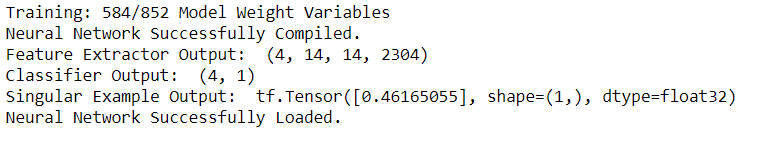

In [10]:
DROPOUT = False

# Network Architecture
if (NN_COLOR=='multi'):
    input_layer      = tf.keras.layers.Input(shape=(DIM_X,DIM_Y,DIM_CHANNELS))
    conv1x1          = tf.keras.layers.Conv2D(filters=3, kernel_size=1, strides=(1,1))(input_layer)

  # Feature Extractor Layers
    encoder          = efn.EfficientNetB0(input_tensor=conv1x1, include_top=False, weights=None)

      # Classifier Layers
    globavgpool_out  = tf.keras.layers.GlobalAveragePooling2D()(encoder.output)
    predictions      = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), activation='sigmoid')(globavgpool_out)
    model            = tf.keras.models.Model(inputs=input_layer,outputs=predictions)

elif (NN_COLOR=='single'):
    encoder        = tf.keras.applications.InceptionV3(input_shape=(DIM_X,DIM_Y,DIM_CHANNELS), include_top=False, weights=NN_WEIGHTS)
    if   (NN_FINETUNE=='full'):# Finetune Full Model
        encoder.Trainable = True
    elif (NN_FINETUNE=='classifier'):# Finetune Classifier Only
        encoder.Trainable = False 
    else:# Finetune Specific Layers
        layer_names  = [layer.name for layer in encoder.layers]
        fine_tune_at = layer_names.index(NN_FINETUNE)
        for layer in encoder.layers[:fine_tune_at]:
            layer.trainable =  False
        print("Finetuning: " + str(len(encoder.trainable_weights)) + "/" 
              + str(len(encoder.weights)) + " Encoder Weights Variables")
    globavgpool_out  = tf.keras.layers.GlobalAveragePooling2D()(encoder.output)
    if (DROPOUT==True):
        dense_01         = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), activation='relu')(globavgpool_out)
        dropout_01       = tf.keras.layers.Dropout(0.25)(dense_01)
        #dense_02         = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), activation='relu')(dropout_01)
        #dropout_02       = tf.keras.layers.Dropout(0.25)(dense_02)
        predictions      = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), activation='sigmoid')(dropout_01)
    else:
        predictions      = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), activation='sigmoid')(globavgpool_out)
        model            = tf.keras.models.Model(inputs=encoder.input,outputs=predictions)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss      = 'binary_crossentropy',
              metrics   = ['accuracy'])

print("Training: " + str(len(model.trainable_weights)) + "/" 
          + str(len(model.weights)) + " Model Weight Variables")

print('Neural Network Successfully Compiled.')

# Verify Output Shapes (Redundancy Check)
print('Feature Extractor Output: ', encoder(image_batch).shape)
print('Classifier Output: ',        model(image_batch).shape)
print('Singular Example Output: ',  model(image_batch)[0])
print('Neural Network Successfully Loaded.')


In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [27]:
TRAIN_SCHEME = 'resume'
EPOCHS       = 50
AUX_EPOCHS   = 50

# CLEAN
if (TRAIN_SCHEME=='clean'):# Fit Training Data to Labels
    history = model.fit(train_dataset,
                      steps_per_epoch  = round(TRAIN_SAMPLES)//BATCH_SIZE,
                      epochs           = EPOCHS,
                      initial_epoch    = 0,                   # Fine-Tuning/Resume Training ("history.epoch[-1]+1")
                      validation_steps = round(VAL_SAMPLES)//BATCH_SIZE,
                      validation_data  = val_dataset,
                      callbacks        = CALLBACKS)
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']
    acc.insert(0,0)
    val_acc.insert(0,0)
    loss.insert(0,100)
    val_loss.insert(0,100)

# FREEZE
elif (TRAIN_SCHEME=='freeze'):# Fit Training Data to Labels
    history = model.fit(train_dataset,
                      steps_per_epoch  = round(TRAIN_SAMPLES)//BATCH_SIZE,
                      epochs           = EPOCHS,
                      initial_epoch    = 0,                   # Fine-Tuning/Resume Training ("history.epoch[-1]+1")
                      validation_steps = round(VAL_SAMPLES)//BATCH_SIZE,
                      validation_data  = val_dataset,
                      callbacks        = CALLBACKS)
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']
    acc.insert(0,0)
    val_acc.insert(0,0)
    loss.insert(0,100)
    val_loss.insert(0,100)
    for layer in model.layers[:660]:
        layer.trainable =  False

      # Fit Training Data to Labels
      history = model.fit(train_dataset,
                          steps_per_epoch  = round(TRAIN_SAMPLES)//BATCH_SIZE,
                          epochs           = EPOCHS+AUX_EPOCHS,
                          initial_epoch    = history.epoch[-1]+1,    # Fine-Tuning/Resume Training ("history.epoch[-1]+1")
                          validation_steps = round(VAL_SAMPLES)//BATCH_SIZE,
                          validation_data  = val_dataset,
                          callbacks        = CALLBACKS)

  # Evaluation Metrics
      acc      += history.history['accuracy']
      val_acc  += history.history['val_accuracy']
    loss     += history.history['loss']
      val_loss += history.history['val_loss']

# RESUME
elif (TRAIN_SCHEME=='resume'):
  # Fit Training Data to Labels
  history = model.fit(train_dataset,
                      steps_per_epoch  = round(TRAIN_SAMPLES)//BATCH_SIZE,
                      epochs           = EPOCHS+AUX_EPOCHS,
                      initial_epoch    = history.epoch[-1]+1,    # Fine-Tuning/Resume Training ("history.epoch[-1]+1")
                      validation_steps = round(VAL_SAMPLES)//BATCH_SIZE,
                      validation_data  = val_dataset,
                      callbacks        = CALLBACKS)
    acc      += history.history['accuracy']
    val_acc  += history.history['val_accuracy']
    loss     += history.history['loss']
    val_loss += history.history['val_loss']

Epoch 1/50
225/225 [==============================] - 69s 307ms/step - loss: 1.0431 - accuracy: 0.6344 - val_loss: 0.9404 - val_accuracy: 0.6359
Epoch 2/50
225/225 [==============================] - 46s 205ms/step - loss: 0.8045 - accuracy: 0.7027 - val_loss: 1.4229 - val_accuracy: 0.3429
Epoch 3/50
225/225 [==============================] - 47s 210ms/step - loss: 0.7186 - accuracy: 0.7419 - val_loss: 0.7441 - val_accuracy: 0.7394
Epoch 4/50
225/225 [==============================] - 47s 210ms/step - loss: 0.7636 - accuracy: 0.7140 - val_loss: 1.8031 - val_accuracy: 0.3105
Epoch 5/50
225/225 [==============================] - 47s 209ms/step - loss: 0.7596 - accuracy: 0.7112 - val_loss: 0.7270 - val_accuracy: 0.7145
Epoch 6/50
225/225 [==============================] - 47s 207ms/step - loss: 0.7276 - accuracy: 0.7264 - val_loss: 0.7462 - val_accuracy: 0.7195

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
225/225 [=============================

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 1s 2ms/step
Validation: accuracy = 0.811721  ;  loss_v = 0.669623
Test: accuracy = 0.822766  ;  loss = 0.622511


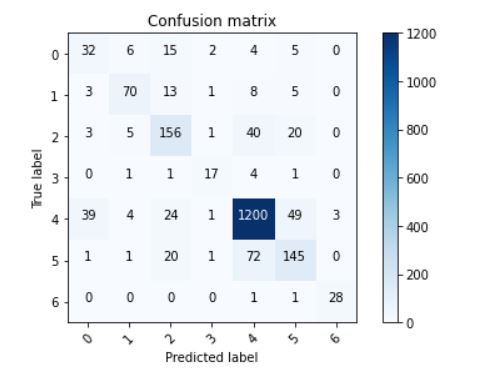

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

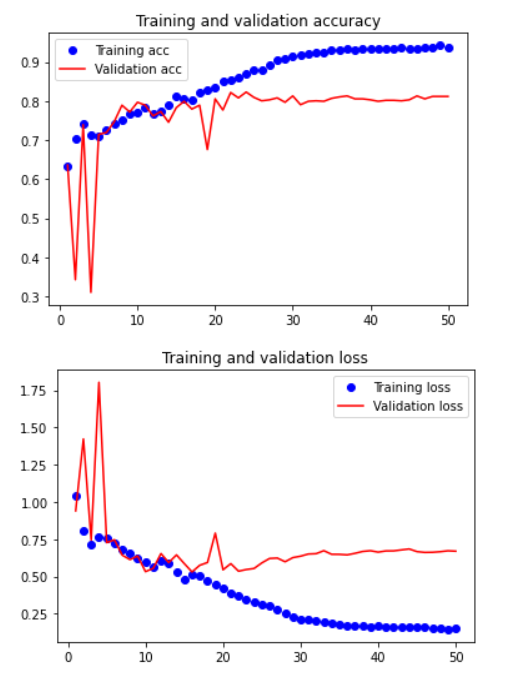

In [13]:
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

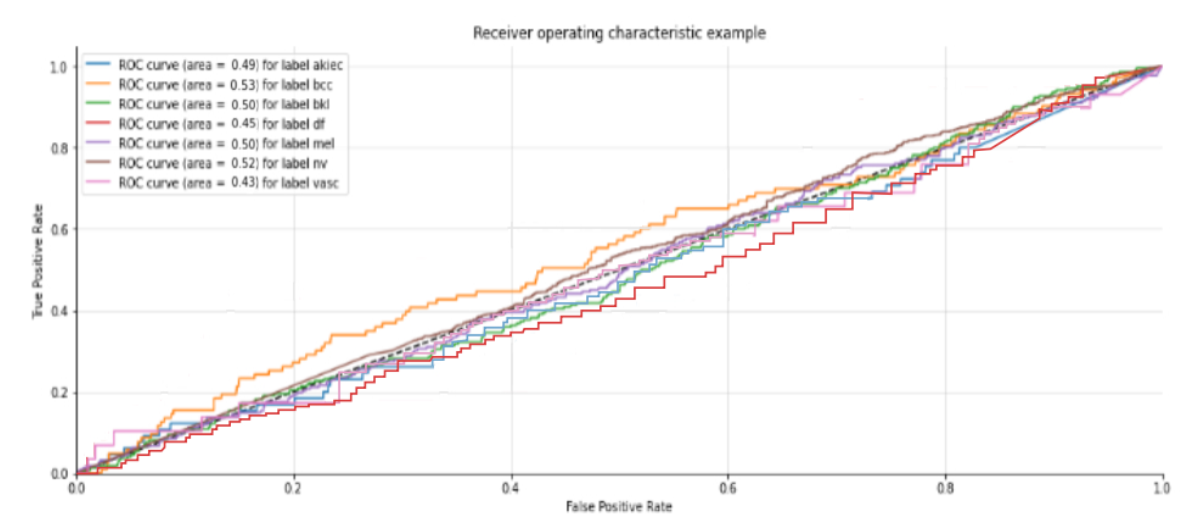

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
# calculate roc curve
test_labels2=test_labels[:-17]
# structures
fpr = dict()
tpr = dict()
roc_auc = dict()
# calculate dummies once
y_test_dummies = pd.get_dummies(test_labels1, drop_first=False).values
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# roc for each class
fig, ax = plt.subplots(figsize=(17,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],cm_plot_labels[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()